In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from copy import deepcopy

In [29]:
import svg
from hehe2 import *
from IPython.display import SVG, display
import itertools
from collections import defaultdict

In [5]:
def show_svg(canvas: svg.SVG):
    display(SVG(str(canvas)))

In [6]:
def test_ValuedArrow_func():
    arrows = {2: ['←','→'], 3: [ "↑", "↓"], 6: ["↖","↘"]}
    for j in [2,3,6]:
        for i in range(j):
            va = ValuedArrow(arrows[j][0], i)
            assert va.func() == (va.x - i)/j
            va = ValuedArrow(arrows[j][1], i)
            assert va.func() == j*va.x + i

    for j in range(6):
        east = j%3
        south = j%2
        va = ValuedArrow("↙",j)
        assert va.func() == ((3*va.x+east)-south)/2
        va2 = ValuedArrow("↗",j)
        assert compose(va.func(), va2.func(),va.x) == va.x
test_ValuedArrow_func()

In [7]:
def test_ValuedPath_func_via_pv(num_tests=100, len_pv=10):
    for _ in range(num_tests):
        pv = coreli.ParityVector.get_random_parity_vector(len_pv)
        a, b = pv.first_occurrence()
        vap = ValuedPath.from_parity_vector(pv)
        assert(vap.func().subs(vap.x,a) == b)
test_ValuedPath_func_via_pv()

In [8]:
def test_world_read_via_pv(num_tests=1000, len_pv=10):
    for _ in range(num_tests):
        pv = coreli.ParityVector.get_random_parity_vector(len_pv)
        vap = ValuedPath.from_parity_vector(pv)
        world2 = World()
        world2.place_initial_valued_path(vap)
        top = world2.read(['→']*len_pv, pos=(-1*len_pv,0), compute_missing=True)
        k = pv.odd_len()
        top_str = "".join(list(map(lambda x: str(x), top.values())))
        a = int(top_str,2)
        if k == 0:
            assert(a == 0)
            return
        
        left = world2.read(['↓']*k, pos=(-1*len_pv,0), compute_missing=True)
        left_str = "".join(list(map(lambda x: str(x), left.values())))
        b = int(left_str,3)
        assert(coreli.iterate(coreli.T, len_pv, a) == b)
test_world_read_via_pv()

## A

In [9]:
pv = coreli.ParityVector([0, 1, 0, 1, 1, 0])
pv_pattern = ["←" if b == 0 else "↙" for b in pv]
vap = ValuedPath.from_parity_vector(pv)
world = World()
world.place_initial_valued_path(vap)
world.read(['→']*len(pv), pos=(-1*len(pv),0), compute_missing=True)

(('→', 1), ('→', 1), ('→', 0), ('→', 0), ('→', 1), ('→', 0))

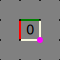

In [10]:
world = World()
world.world = {(0,0): [1,0,0,2], }
canvas = draw_world_svgpy(world.world, highlight_points=[(0,0)])
show_svg(canvas)

## B ↖

(-6, -2)
(('←', 0), ('↙', 0), ('←', 0), ('↙', 3), ('↙', 2))


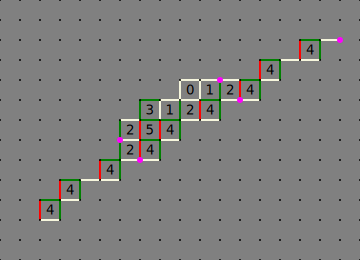

In [11]:
pv_seed = coreli.ParityVector([0, 1, 0, 1, 1])
pv = coreli.ParityVector(pv_seed.parity_vector*3)
pv_pattern = ["←" if b == 0 else "↙" for b in pv_seed]
vap_seed = ValuedPath.from_parity_vector(pv_seed)
vap = ValuedPath.from_parity_vector(pv)
world = World()
world.place_initial_valued_path(vap)

new_origin = (-1*len(pv_seed)-1, -1*pv_seed.odd_len()+1)
print(new_origin)


#IDK why need 2 calls
next_vap = world.read(pv_pattern, pos=new_origin, compute_missing=True)
print(next_vap)
#next_vap = world.read(pv_pattern, pos=new_origin, compute_missing=True)

canvas = draw_world_svgpy(world.world, 
         highlight_points=[(0,0), 
         (-1*len(pv_seed), -1*pv_seed.odd_len()), 
         (-2*len(pv_seed), -2*pv_seed.odd_len()),
         (-2*len(pv_seed)-1, -2*pv_seed.odd_len()+1),
         new_origin])
show_svg(canvas)

#next_vap

In [12]:
def test_next_cyclic_up_left_vap_via_pv(num_tests=100, num_tests_nested=10, len_pv=10):
    for _ in range(num_tests):
        pv = coreli.ParityVector.get_random_parity_vector(len_pv)
        vap = ValuedPath.from_parity_vector(pv)

        for _ in range(num_tests_nested):
            next_vap, varrow = vap.next_cyclic_vap("↖")
    
            vap2 = deepcopy(vap)
            vap2.valued_path = (varrow.opp_varrow(),)+vap2.valued_path
    
            next_vap2 = deepcopy(next_vap)
            next_vap2.valued_path = next_vap2.valued_path + (varrow.opp_varrow(),)
            vap = next_vap

        assert(vap2.func() == next_vap2.func())
test_next_cyclic_up_left_vap_via_pv()

In [16]:
def test_next_cyclic_vap_via_pv(num_tests=100, num_tests_nested=10, len_pv=10):
    for _ in range(num_tests):
        pv = coreli.ParityVector.get_random_parity_vector(len_pv)
        vap = ValuedPath.from_parity_vector(pv)

        for arrow in ["↖", "↗", "←", "↑"]:
            for _ in range(num_tests_nested):
                next_vap, varrow = vap.next_cyclic_vap(arrow)
        
                vap2 = deepcopy(vap)
                vap2.valued_path = (varrow.opp_varrow(),)+vap2.valued_path
        
                next_vap2 = deepcopy(next_vap)
                next_vap2.valued_path = next_vap2.valued_path + (varrow.opp_varrow(),)
                vap = next_vap

                assert(vap2.func() == next_vap2.func())
test_next_cyclic_vap_via_pv()

## C

In [27]:
def compute_components(graph):
    visited = set()
    components = []
    node_to_component = {}

    # Build reverse graph
    reverse_graph = defaultdict(list)
    for u, v in graph.items():
        reverse_graph[v].append(u)

    def explore(start):
        component = set()
        stack = [start]
        while stack:
            node = stack.pop()
            if node is None or node in visited:
                continue
            visited.add(node)
            component.add(node)
            # Explore forward
            next_node = graph.get(node)
            if next_node not in visited:
                stack.append(next_node)
            # Explore backward
            for prev in reverse_graph[node]:
                if prev not in visited:
                    stack.append(prev)
        return component

    for node in graph:
        if node not in visited:
            component = explore(node)
            components.append(component)
            for n in component:
                node_to_component[n] = component

    return components, node_to_component

In [17]:
def enumerate_vap_from_arrows(arrows):
    for valuation in itertools.product(*[ValuedArrow.value_space(arrow) for arrow in arrows]):
        yield ValuedPath.from_arrows_and_valuation(arrows,valuation)

In [18]:
def valuation_space_size(arrows):
    p = 1
    for a in arrows:
        p *= len(ValuedArrow.value_space(a))
    return p

In [140]:
def make_graph(arrows):
    graph = {}
    principal_arrows = ["↖", "↗", "←", "↑"]
    for vap in enumerate_vap_from_arrows(arrows):
        for arrow in principal_arrows:
            next_vap, varrow = vap.next_cyclic_vap(arrow)
            if vap not in graph:
                graph[vap] = {}
            graph[vap][varrow] = next_vap
    return graph

In [141]:
def sub_graph(graph, arrow='↖'):
    subgraph = {}
    for node in graph:
        for edge in graph[node]:
            if edge.arrow == arrow:
                subgraph[node] = graph[node][edge]
    return subgraph

In [186]:
def distance(graph, src, dst):
    seen = set({})
    dist = 0
    while src != dst:
        if src in seen:
            return -1
        seen.add(src)
        src = graph[src]
        dist += 1
    return dist

In [306]:
def distance_to_ring(graph, src):    
    seen = set({})
    dist = 0
    src0 = src
    dist_of_node = {}
    ring_size = 0
    while src not in seen:
        dist_of_node[src] = dist
        seen.add(src)
        src = graph[src]
        dist += 1
    ring_size = dist - dist_of_node[src]
    if src0 == src:
        return 0,ring_size
    return dist-ring_size,ring_size

In [336]:
def get_ring(graph, src):
    seen = set({})
    while src not in seen:
        seen.add(src)
        src = graph[src]

    #src is in ring
    seen = set({})
    ring = []
    while src not in seen:
        seen.add(src)
        ring.append(src)
        src = graph[src]
    return ring

In [482]:
pv = coreli.ParityVector([1]*5+[0]*2)
pv = coreli.ParityVector.get_random_parity_vector(4)
pv.parity_vector = [1] + pv.parity_vector
vap_pv = ValuedPath.from_parity_vector(pv)
arrows = vap_pv.arrows()
arrows

['↙', '↙', '↙', '↙', '←']

In [483]:
print(2**len(pv.parity_vector)-3**(pv.odd_len()))

-49


In [484]:
valuation_space_size(arrows)

2592

In [485]:
zero = ValuedPath.from_arrows_and_valuation(arrows, [0]*len(arrows))
zero

(('↙', 0), ('↙', 0), ('↙', 0), ('↙', 0), ('←', 0))

In [486]:
graph = make_graph(arrows)
subgraph = sub_graph(graph)
components, node_to_component = compute_components(subgraph)

In [487]:
for comp in components:
    node = list(comp)[0]
    _, ring_size = distance_to_ring(subgraph, node)
    ring = get_ring(subgraph, node)
    ring_frac = [n.func().subs(n.x,0) for n in ring]
    print(ring_size,min(ring_frac),end='')
    if vap_pv in comp:
        print("*")
    else:
        print()
    if ring_size == 1:
        print(ring[0])
    for frac in ring_frac:
        print("  ", frac)

1 0
(('↙', 0), ('↙', 0), ('↙', 0), ('↙', 0), ('←', 0))
   0
14 1/16*
   9/32
   13/16
   37/32
   47/32
   1/2
   19/32
   11/8
   5/4
   23/32
   3/8
   1/16
   33/32
   15/16
   5/32
14 1/32
   1/4
   17/16
   11/16
   5/8
   9/8
   3/16
   1/32
   41/32
   15/32
   27/32
   29/32
   13/32
   43/32
   3/2
14 3/32
   5/16
   9/16
   3/32
   25/32
   45/32
   1
   19/16
   39/32
   31/32
   23/16
   3/4
   1/8
   17/32
   11/32
2 21/32
   21/32
   7/8
2 7/32
   7/32
   21/16
2 7/16
   7/16
   35/32
1 49/32
(('↙', 5), ('↙', 5), ('↙', 5), ('↙', 5), ('←', 1))
   49/32


## D

In [118]:
def enumerate_pv_without_rotation(len_pv):
    seen = {}
    for pv in itertools.product([0,1], repeat=len_pv):
        pv_c = coreli.ParityVector(pv)
        rot_seen = False
        for i in range(len(pv)):
            pv_c_r = pv_c.rotate(i)
            if tuple(pv_c_r.parity_vector) in seen:
                rot_seen = True
                break
        if rot_seen:
            continue

        seen[pv] = True
        yield coreli.ParityVector(pv)

In [427]:
for pv in enumerate_pv_without_rotation(6):
    if sum(pv) == 0:
        continue
    print(pv)
    vap_pv = ValuedPath.from_parity_vector(pv)
    arrows = vap_pv.arrows()
    zero = ValuedPath.from_arrows_and_valuation(arrows, [0]*len(arrows)).to_tuple()
    graph = make_graph(arrows)
    subgraph = sub_graph(graph)
    components, node_to_component = compute_components(subgraph)
    
    for comp in components:
        node = list(comp)[0]
        _, ring_size = distance_to_ring(subgraph, node)
        ring = get_ring(subgraph, node)
        ring_frac = [n.func().subs(n.x,0) for n in ring]
        print(ring_size,end='')
        if vap_pv in comp:
            print("*")
        else:
            print()
        if ring_size == 1:
            print(ring[0])
    print()
    print()

(0, 0, 0, 0, 0, 1)
1
(('←', 0), ('←', 0), ('←', 0), ('←', 0), ('←', 0), ('↙', 0))
60*
1
(('←', 1), ('←', 1), ('←', 1), ('←', 1), ('←', 1), ('↙', 5))


(0, 0, 0, 0, 1, 1)
1
(('←', 0), ('←', 0), ('←', 0), ('←', 0), ('↙', 0), ('↙', 0))
10
10
10
10
10*
1
(('←', 0), ('←', 1), ('←', 1), ('←', 0), ('↙', 1), ('↙', 4))
1
(('←', 1), ('←', 0), ('←', 0), ('←', 1), ('↙', 4), ('↙', 1))
1
(('←', 1), ('←', 1), ('←', 0), ('←', 0), ('↙', 3), ('↙', 2))
1
(('←', 0), ('←', 0), ('←', 1), ('←', 1), ('↙', 2), ('↙', 3))
1
(('←', 1), ('←', 1), ('←', 1), ('←', 1), ('↙', 5), ('↙', 5))


(0, 0, 0, 1, 0, 1)
1
(('←', 0), ('←', 0), ('←', 0), ('↙', 0), ('←', 0), ('↙', 0))
10
10
10
10*
10
1
(('←', 0), ('←', 1), ('←', 1), ('↙', 2), ('←', 1), ('↙', 4))
1
(('←', 1), ('←', 1), ('←', 0), ('↙', 1), ('←', 1), ('↙', 2))
1
(('←', 0), ('←', 0), ('←', 1), ('↙', 4), ('←', 0), ('↙', 3))
1
(('←', 1), ('←', 0), ('←', 0), ('↙', 3), ('←', 0), ('↙', 1))
1
(('←', 1), ('←', 1), ('←', 1), ('↙', 5), ('←', 1), ('↙', 5))


(0, 0, 0, 1, 1, 1)


In [428]:
for pv in enumerate_pv_without_rotation(7):
    if sum(pv) == 0:
        continue
    print(pv)
    vap_pv = ValuedPath.from_parity_vector(pv)
    arrows = vap_pv.arrows()
    zero = ValuedPath.from_arrows_and_valuation(arrows, [0]*len(arrows)).to_tuple()
    graph = make_graph(arrows)
    subgraph = sub_graph(graph)
    components, node_to_component = compute_components(subgraph)
    
    for comp in components:
        node = list(comp)[0]
        _, ring_size = distance_to_ring(subgraph, node)
        ring = get_ring(subgraph, node)
        ring_frac = [n.func().subs(n.x,0) for n in ring]
        print(ring_size,end='')
        if vap_pv in comp:
            print("*")
        else:
            print()
        if ring_size == 1:
            print(ring[0])
    print()
    print()

(0, 0, 0, 0, 0, 0, 1)
1
(('←', 0), ('←', 0), ('←', 0), ('←', 0), ('←', 0), ('←', 0), ('↙', 0))
25
25
25*
25
5
5
5
5
1
(('←', 0), ('←', 0), ('←', 1), ('←', 1), ('←', 0), ('←', 0), ('↙', 3))
1
(('←', 1), ('←', 1), ('←', 0), ('←', 0), ('←', 1), ('←', 1), ('↙', 2))
1
(('←', 1), ('←', 0), ('←', 0), ('←', 1), ('←', 1), ('←', 0), ('↙', 1))
1
(('←', 0), ('←', 1), ('←', 1), ('←', 0), ('←', 0), ('←', 1), ('↙', 4))
1
(('←', 1), ('←', 1), ('←', 1), ('←', 1), ('←', 1), ('←', 1), ('↙', 5))


(0, 0, 0, 0, 0, 1, 1)
1
(('←', 0), ('←', 0), ('←', 0), ('←', 0), ('←', 0), ('↙', 0), ('↙', 0))
16
16
16*
16
16
16
16
2
2
2
1
(('←', 1), ('←', 1), ('←', 1), ('←', 1), ('←', 1), ('↙', 5), ('↙', 5))


(0, 0, 0, 0, 1, 0, 1)
1
(('←', 0), ('←', 0), ('←', 0), ('←', 0), ('↙', 0), ('←', 0), ('↙', 0))
16
16
16
16
16
16
16*
2
2
2
1
(('←', 1), ('←', 1), ('←', 1), ('←', 1), ('↙', 5), ('←', 1), ('↙', 5))


(0, 0, 0, 0, 1, 1, 1)
1
(('←', 0), ('←', 0), ('←', 0), ('←', 0), ('↙', 0), ('↙', 0), ('↙', 0))
10
10
10
10*
10
10
10
10
1

In [429]:
for pv in enumerate_pv_without_rotation(8):
    if sum(pv) == 0:
        continue
    print(pv)
    vap_pv = ValuedPath.from_parity_vector(pv)
    arrows = vap_pv.arrows()
    zero = ValuedPath.from_arrows_and_valuation(arrows, [0]*len(arrows)).to_tuple()
    graph = make_graph(arrows)
    subgraph = sub_graph(graph)
    components, node_to_component = compute_components(subgraph)
    
    for comp in components:
        node = list(comp)[0]
        _, ring_size = distance_to_ring(subgraph, node)
        ring = get_ring(subgraph, node)
        ring_frac = [n.func().subs(n.x,0) for n in ring]
        print(ring_size,end='')
        if vap_pv in comp:
            print("*")
        else:
            print()
        if ring_size == 1:
            print(ring[0])
    print()
    print()

(0, 0, 0, 0, 0, 0, 0, 1)
1
(('←', 0), ('←', 0), ('←', 0), ('←', 0), ('←', 0), ('←', 0), ('←', 0), ('↙', 0))
110*
110
11
10
11
1
(('←', 1), ('←', 1), ('←', 1), ('←', 1), ('←', 1), ('←', 1), ('←', 1), ('↙', 5))


(0, 0, 0, 0, 0, 0, 1, 1)
1
(('←', 0), ('←', 0), ('←', 0), ('←', 0), ('←', 0), ('←', 0), ('↙', 0), ('↙', 0))
36
36
36
36*
9
36
12
36
9
1
(('←', 1), ('←', 1), ('←', 1), ('←', 1), ('←', 1), ('←', 1), ('↙', 5), ('↙', 5))


(0, 0, 0, 0, 0, 1, 0, 1)
1
(('←', 0), ('←', 0), ('←', 0), ('←', 0), ('←', 0), ('↙', 0), ('←', 0), ('↙', 0))
36
36
36*
36
9
36
9
12
36
1
(('←', 1), ('←', 1), ('←', 1), ('←', 1), ('←', 1), ('↙', 5), ('←', 1), ('↙', 5))


(0, 0, 0, 0, 0, 1, 1, 1)
1
(('←', 0), ('←', 0), ('←', 0), ('←', 0), ('←', 0), ('↙', 0), ('↙', 0), ('↙', 0))
228*
1
(('←', 1), ('←', 1), ('←', 1), ('←', 1), ('←', 1), ('↙', 5), ('↙', 5), ('↙', 5))


(0, 0, 0, 0, 1, 0, 0, 1)
1
(('←', 0), ('←', 0), ('←', 0), ('←', 0), ('↙', 0), ('←', 0), ('←', 0), ('↙', 0))
36
36
36
36
9
36
9
12
36*
1
(('←', 1), ('←', 

In [125]:
for pv in enumerate_pv_without_rotation(5):
    if sum(pv) == 0:
        continue
    vap_pv = ValuedPath.from_parity_vector(pv)
    arrows = vap_pv.arrows()
    zero = ValuedPath.from_arrows_and_valuation(arrows, [0]*len(arrows)).to_tuple()
    graph = make_graph(arrows)
    subgraph = sub_graph(graph)
    components, node_to_component = compute_components(subgraph)
    print(pv, len(graph), len(components), len(node_to_component[vap_pv.to_tuple()]), len(node_to_component[zero]))

(0, 0, 0, 0, 1) 96 4 46 3
(0, 0, 0, 1, 1) 288 4 135 9
(0, 0, 1, 0, 1) 288 4 135 9
(0, 0, 1, 1, 1) 864 6 175 90
(0, 1, 0, 1, 1) 864 6 172 87
(0, 1, 1, 1, 1) 2592 8 740 37
(1, 1, 1, 1, 1) 7776 4 33 33


In [126]:
for pv in enumerate_pv_without_rotation(6):
    if sum(pv) == 0:
        continue
    vap_pv = ValuedPath.from_parity_vector(pv)
    arrows = vap_pv.arrows()
    zero = ValuedPath.from_arrows_and_valuation(arrows, [0]*len(arrows)).to_tuple()
    graph = make_graph(arrows)
    subgraph = sub_graph(graph)
    components, node_to_component = compute_components(subgraph)
    print(pv, len(graph), len(components), len(node_to_component[vap_pv.to_tuple()]), len(node_to_component[zero]))

(0, 0, 0, 0, 0, 1) 192 3 186 3
(0, 0, 0, 0, 1, 1) 576 11 100 9
(0, 0, 0, 1, 0, 1) 576 11 106 9
(0, 0, 0, 1, 1, 1) 1728 11 182 27
(0, 0, 1, 0, 0, 1) 576 11 13 9
(0, 0, 1, 0, 1, 1) 1728 11 196 31
(0, 0, 1, 1, 0, 1) 1728 11 180 29
(0, 0, 1, 1, 1, 1) 5184 3 4866 159
(0, 1, 0, 1, 0, 1) 1728 11 36 36
(0, 1, 0, 1, 1, 1) 5184 3 4856 164
(0, 1, 1, 0, 1, 1) 5184 3 184 184
(0, 1, 1, 1, 1, 1) 15552 3 15414 69
(1, 1, 1, 1, 1, 1) 46656 61 65 65


In [127]:
for pv in enumerate_pv_without_rotation(7):
    if sum(pv) == 0:
        continue
    vap_pv = ValuedPath.from_parity_vector(pv)
    arrows = vap_pv.arrows()
    zero = ValuedPath.from_arrows_and_valuation(arrows, [0]*len(arrows)).to_tuple()
    graph = make_graph(arrows)
    subgraph = sub_graph(graph)
    components, node_to_component = compute_components(subgraph)
    print(pv, len(graph), len(components), len(node_to_component[vap_pv.to_tuple()]), len(node_to_component[zero]))

(0, 0, 0, 0, 0, 0, 1) 384 14 77 3
(0, 0, 0, 0, 0, 1, 1) 1152 12 155 9
(0, 0, 0, 0, 1, 0, 1) 1152 12 154 9
(0, 0, 0, 0, 1, 1, 1) 3456 12 340 27
(0, 0, 0, 1, 0, 0, 1) 1152 12 155 9
(0, 0, 0, 1, 0, 1, 1) 3456 12 362 27
(0, 0, 0, 1, 1, 0, 1) 3456 12 342 27
(0, 0, 0, 1, 1, 1, 1) 10368 4 5060 124
(0, 0, 1, 0, 0, 1, 1) 3456 12 364 27
(0, 0, 1, 0, 1, 0, 1) 3456 12 342 27
(0, 0, 1, 0, 1, 1, 1) 10368 4 5050 134
(0, 0, 1, 1, 0, 1, 1) 10368 4 5065 119
(0, 0, 1, 1, 1, 0, 1) 10368 4 5063 121
(0, 0, 1, 1, 1, 1, 1) 31104 16 3039 161
(0, 1, 0, 1, 0, 1, 1) 10368 4 5060 124
(0, 1, 0, 1, 1, 1, 1) 31104 16 2947 159
(0, 1, 1, 0, 1, 1, 1) 31104 16 2961 153
(0, 1, 1, 1, 1, 1, 1) 93312 10 11983 133
(1, 1, 1, 1, 1, 1, 1) 279936 34 129 129
